In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

df = pd.read_csv('blood_transfusion.csv', na_values=['NA', 'null', '', 'NULL']) 


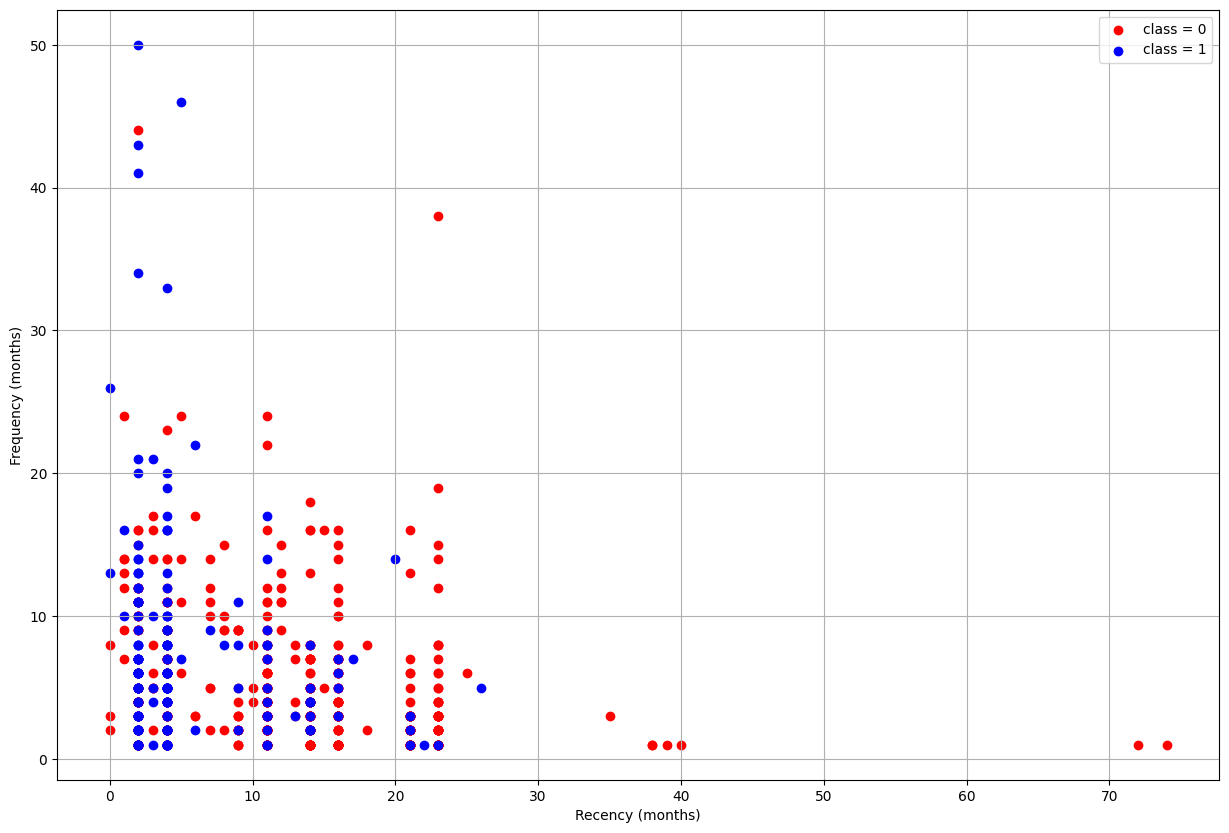

In [3]:
df.describe()
loc_df_class_0 = df.loc[df['class'] == 0]
loc_df_class_1 = df.loc[df['class'] == 1]

# plot the data showing the difference in the two classes 0 and 1
# make the graph bigger to see the data more clearly
# insert so that graph shows all intergers on the x and y axis
plt.figure(figsize=(15, 10))
plt.scatter(loc_df_class_0['months_since_last_donation'], loc_df_class_0['total_number_of_donations'], color='red', label='class = 0')
plt.scatter(loc_df_class_1['months_since_last_donation'], loc_df_class_1['total_number_of_donations'], color='blue', label='class = 1')
plt.xlabel('Recency (months)')
plt.ylabel('Frequency (months)')
plt.legend()
plt.grid()
plt.show()


C:\Users\daanv\AppData\Local\Temp\ipykernel_20900\3216495712.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  loc_df_class_0_more_than_1 = loc_df_class_0[df['total_number_of_donations'] != 1]
C:\Users\daanv\AppData\Local\Temp\ipykernel_20900\3216495712.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  loc_df_class_1_more_than_1 = loc_df_class_1[df['total_number_of_donations'] != 1]


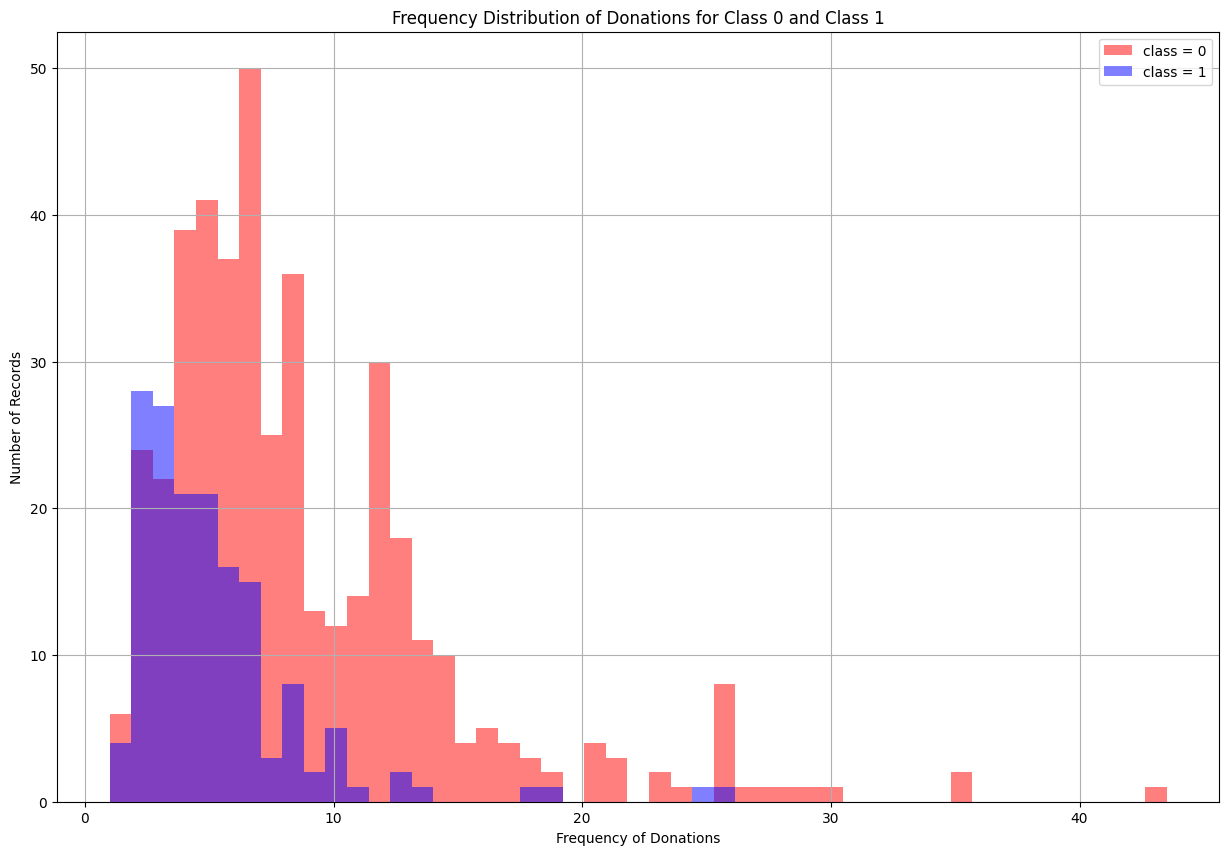

In [46]:
import numpy as np
import matplotlib.pyplot as plt

loc_df_class_0_more_than_1 = loc_df_class_0[df['total_number_of_donations'] != 1]
loc_df_class_1_more_than_1 = loc_df_class_1[df['total_number_of_donations'] != 1]

# Calculate frequency for class 0
freq_class_0 = loc_df_class_0_more_than_1['months_since_first_donation'] / loc_df_class_0_more_than_1['total_number_of_donations']

# Calculate frequency for class 1
freq_class_1 = loc_df_class_1_more_than_1['months_since_first_donation'] / loc_df_class_1_more_than_1['total_number_of_donations']

# Define the number of bins (adjust based on your data distribution)
bins = np.linspace(min(freq_class_0.min(), freq_class_1.min()), max(freq_class_0.max(), freq_class_1.max()), 50)

plt.figure(figsize=(15, 10))

# Create a histogram for class 0
hist_class_0, bins_class_0 = np.histogram(freq_class_0, bins=bins)
plt.bar(bins_class_0[:-1], hist_class_0, width=np.diff(bins_class_0), align='edge', color='red', alpha=0.5, label='class = 0')

# Create a histogram for class 1
hist_class_1, bins_class_1 = np.histogram(freq_class_1, bins=bins)
plt.bar(bins_class_1[:-1], hist_class_1, width=np.diff(bins_class_1), align='edge', color='blue', alpha=0.5, label='class = 1')

plt.xlabel('Frequency of Donations')
plt.ylabel('Number of Records')
plt.title('Frequency Distribution of Donations for Class 0 and Class 1')
plt.legend()
plt.grid()
plt.show()



In [45]:
# Seeing in the dataset if there are records that have donated more than once per month
loc_df_total_minus_last = (df['months_since_first_donation'] - df['months_since_last_donation']) + 1
filtered_df_more_than_once_a_month = df[df['total_number_of_donations'] > loc_df_total_minus_last]

print(len(filtered_df_more_than_once_a_month))

36


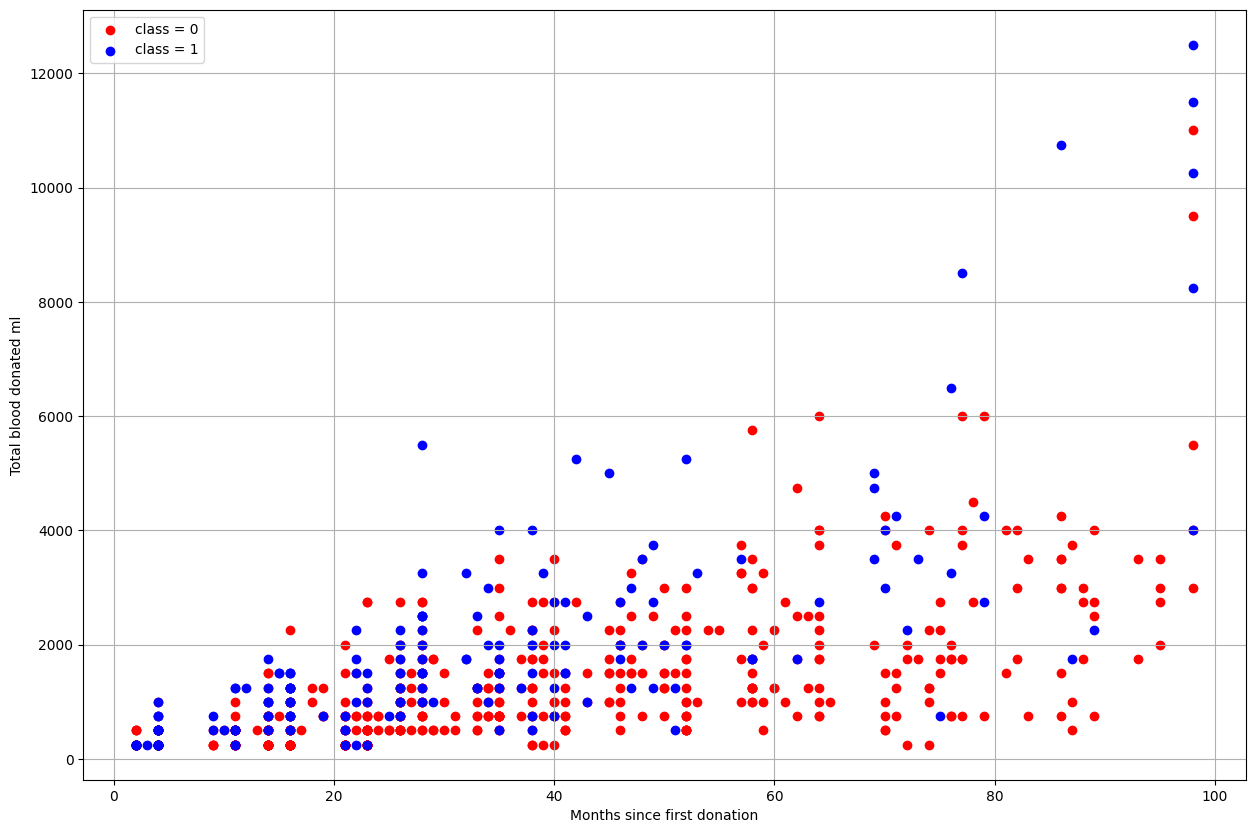

In [4]:
df.describe()
loc_df_class_0 = df.loc[df['class'] == 0]
loc_df_class_1 = df.loc[df['class'] == 1]

# plot the data showing the difference in the two classes 0 and 1
# make the graph bigger to see the data more clearly
# insert so that graph shows all intergers on the x and y axis
plt.figure(figsize=(15, 10))
plt.scatter(loc_df_class_0['months_since_first_donation'], loc_df_class_0['total_blood_donated'], color='red', label='class = 0')
plt.scatter(loc_df_class_1['months_since_first_donation'], loc_df_class_1['total_blood_donated'], color='blue', label='class = 1')
plt.xlabel('Months since first donation')
plt.ylabel('Total blood donated ml')
plt.legend()
plt.grid()

plt.show()

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming df is your DataFrame and 'target' is the column with labels
X = df.drop(columns=['class'])
y = df['class']


scaler = StandardScaler()
df['total_blood_donated'] = scaler.fit_transform(df[['total_blood_donated']])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42) # 80/20 split is good for big datasets where 20% is enough to test the model and 80% is enough to train the model

# Train the model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


Accuracy: 0.7466666666666667
Precision: 0.7131192321889995
Recall: 0.7466666666666667
F1 Score: 0.7200987935784173
